# Predictive Analysis & Early Detection of Brain stroke using Machine Learning Algorithm

## Imports and Settings

In [ ]:
# Standard libraries
import os
import warnings

warnings.filterwarnings("ignore")

# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import matplotlib.gridspec as grid_spec

# Machine learning - preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

# Machine learning - model selection
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    RandomizedSearchCV,
    StratifiedKFold,
)

# Machine learning - models
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Machine learning - metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    f1_score,
    recall_score,
    accuracy_score,
    precision_score,
    roc_auc_score,
)

# Imbalanced learning
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.metrics import classification_report_imbalanced

# Model interpretation
import shap

shap.initjs()

# Pipeline
from sklearn.pipeline import Pipeline

## Data Pre-processing

In [58]:
## Load the dataset
df = pd.read_csv("data.csv")

In [59]:
df.head(5)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,82,0,1,Yes,Self-employed,Rural,126.46,14.3,never smoked,1.0
1,Female,70,1,0,Yes,Private,Urban,214.77,15.0,formerly smoked,0.0
2,Female,72,0,0,Yes,Private,Rural,63.98,15.1,smokes,1.0
3,Female,81,0,1,Yes,Private,Urban,108.46,15.4,smokes,1.0
4,Female,81,0,0,No,Self-employed,Urban,105.88,15.6,never smoked,1.0


In [60]:
df.tail(5)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3079,Male,66,0,0,Yes,Self-employed,Urban,182.89,NaN,never smoked,1.0
3080,Female,67,1,0,Yes,Govt_job,Urban,234.43,NaN,never smoked,1.0
3081,Female,69,0,1,Yes,Self-employed,Rural,89.19,NaN,smokes,1.0
3082,Male,67,0,0,Yes,Self-employed,Urban,136.79,NaN,smokes,1.0
3083,Female,76,0,0,No,Private,Rural,100.55,NaN,never smoked,1.0


In [61]:
# Exploratory Data Analysis
print("Dataset shape:", df.shape)

Dataset shape: (3084, 11)


In [62]:
# Types of data
print("\nData types:")
print(df.dtypes)


Data types:
gender                object
age                    int64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke               float64
dtype: object


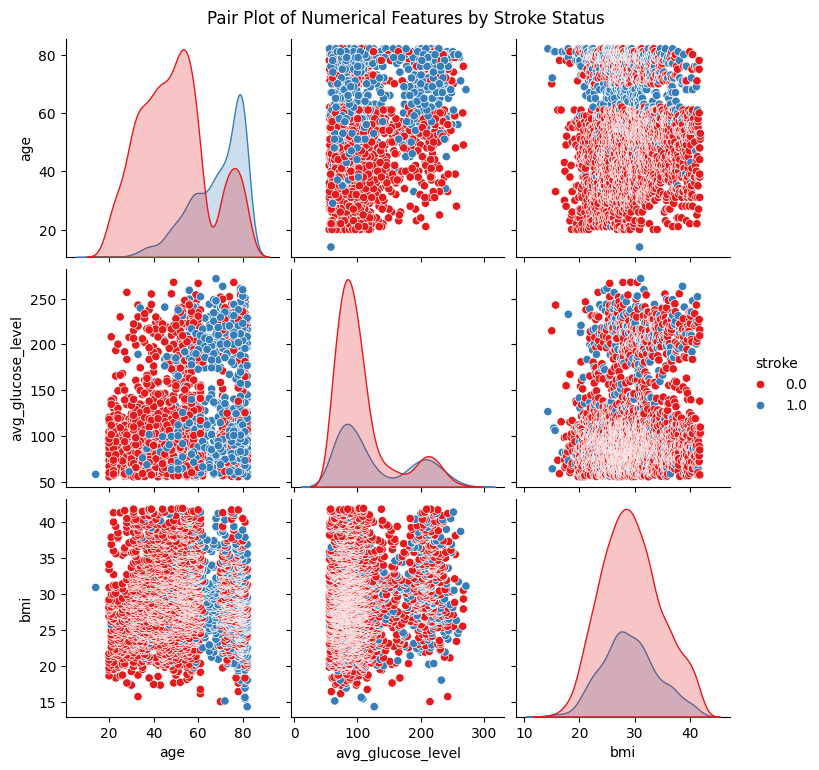

In [63]:
numerical_cols = ["age", "avg_glucose_level", "bmi"]
# pair plot
sns.pairplot(df[numerical_cols + ["stroke"]], hue="stroke", palette="Set1")
plt.suptitle("Pair Plot of Numerical Features by Stroke Status", y=1.02)
plt.show()

In [64]:
# Display the missing values
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  139
smoking_status       138
stroke                 1
dtype: int64



Class distribution:


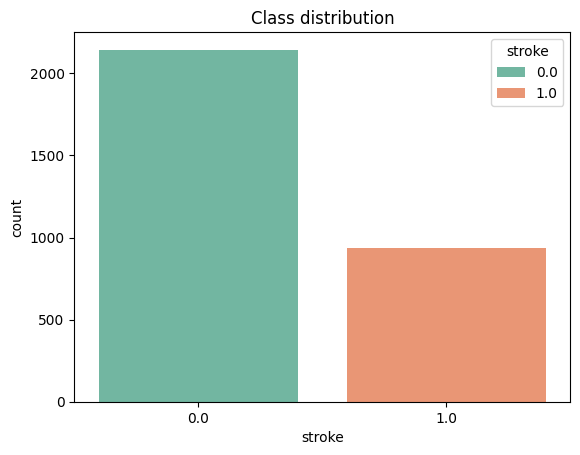

stroke
0.0    2144
1.0     939
Name: count, dtype: int64


In [65]:
print("\nClass distribution:")
sns.countplot(x="stroke", data=df, hue="stroke", palette="Set2")
plt.title("Class distribution")
plt.show()

print(df["stroke"].value_counts())

In [66]:
print(
    f"Imbalance ratio: 1:{df['stroke'].value_counts().iloc[0] / df['stroke'].value_counts().iloc[1]:.1f}"
)

Imbalance ratio: 1:2.3


In [67]:
# Check for non-numeric columns that might cause issues
unique_values_df = pd.DataFrame(
    {
        "Column Name": df.columns,
        "Unique Values": [
            df[col].unique()[:5] for col in df.columns
        ],  # Show first 5 unique values
    }
)

print(unique_values_df)

          Column Name                                 Unique Values
0              gender                                [Male, Female]
1                 age                          [82, 70, 72, 81, 33]
2        hypertension                                        [0, 1]
3       heart_disease                                        [1, 0]
4        ever_married                                     [Yes, No]
5           work_type  [Self-employed, Private, Govt_job, children]
6      Residence_type                                [Rural, Urban]
7   avg_glucose_level       [126.46, 214.77, 63.98, 108.46, 105.88]
8                 bmi                [14.3, 15.0, 15.1, 15.4, 15.6]
9      smoking_status  [never smoked, formerly smoked, smokes, nan]
10             stroke                               [1.0, 0.0, nan]


#### Fill Missing Values

##### For numerical columns

In [68]:
numerical_cols = ["age", "avg_glucose_level", "bmi"]
df.fillna({col: df[col].median() for col in numerical_cols}, inplace=True)

##### For Categorical Columns


In [69]:
categorical_cols = ["gender", "work_type", "Residence_type", "smoking_status", "stroke"]
for col in categorical_cols:
    df.fillna({col: df[col].mode().iloc[0] for col in categorical_cols}, inplace=True)



Stroke Frequency by gender:


stroke,0.0,1.0
gender,,
Female,1284,519
Male,861,420


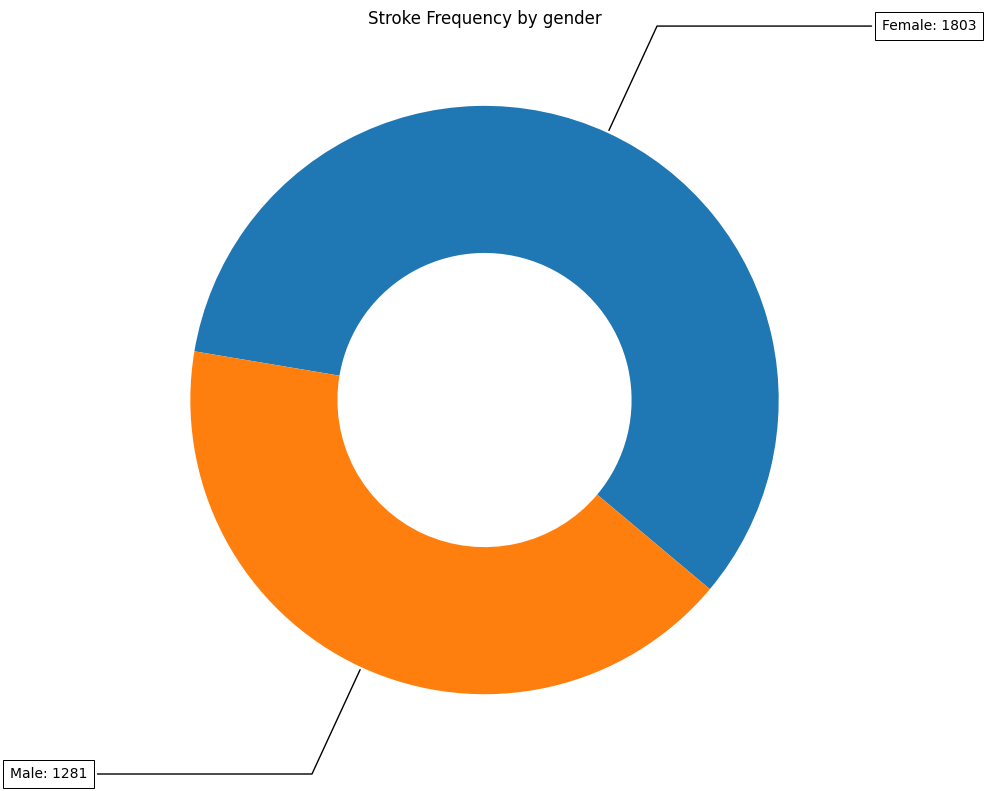


Stroke Frequency by ever_married:


stroke,0.0,1.0
ever_married,,
No,382,96
Yes,1763,843


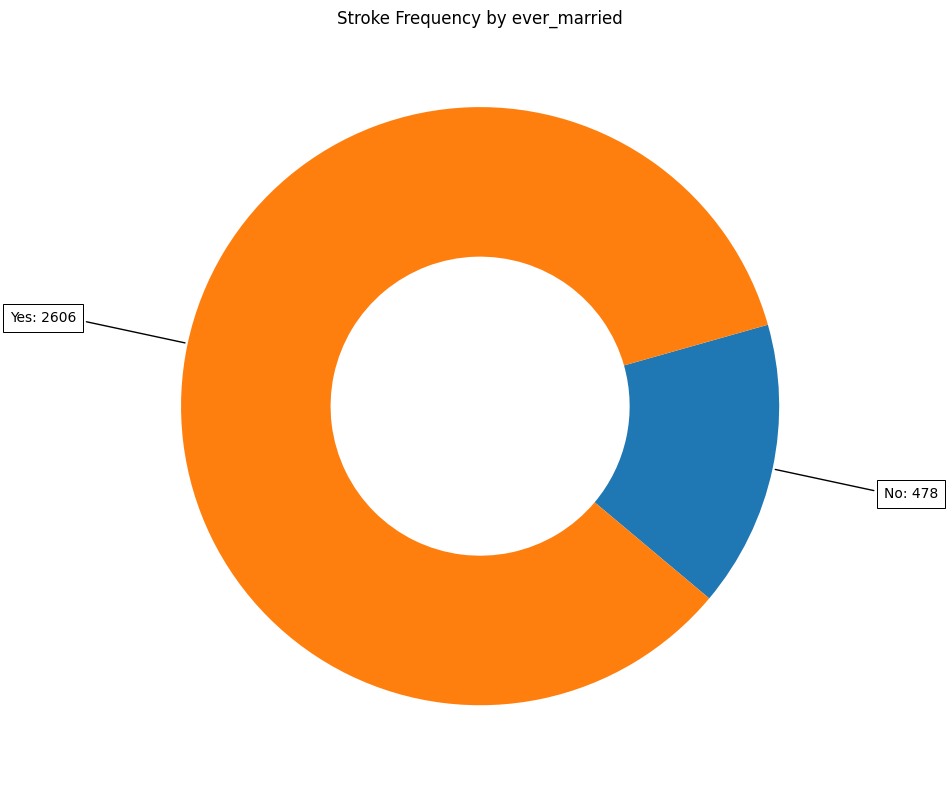


Stroke Frequency by work_type:


stroke,0.0,1.0
work_type,,
Govt_job,360,110
Private,1406,528
Self-employed,379,300
children,0,1


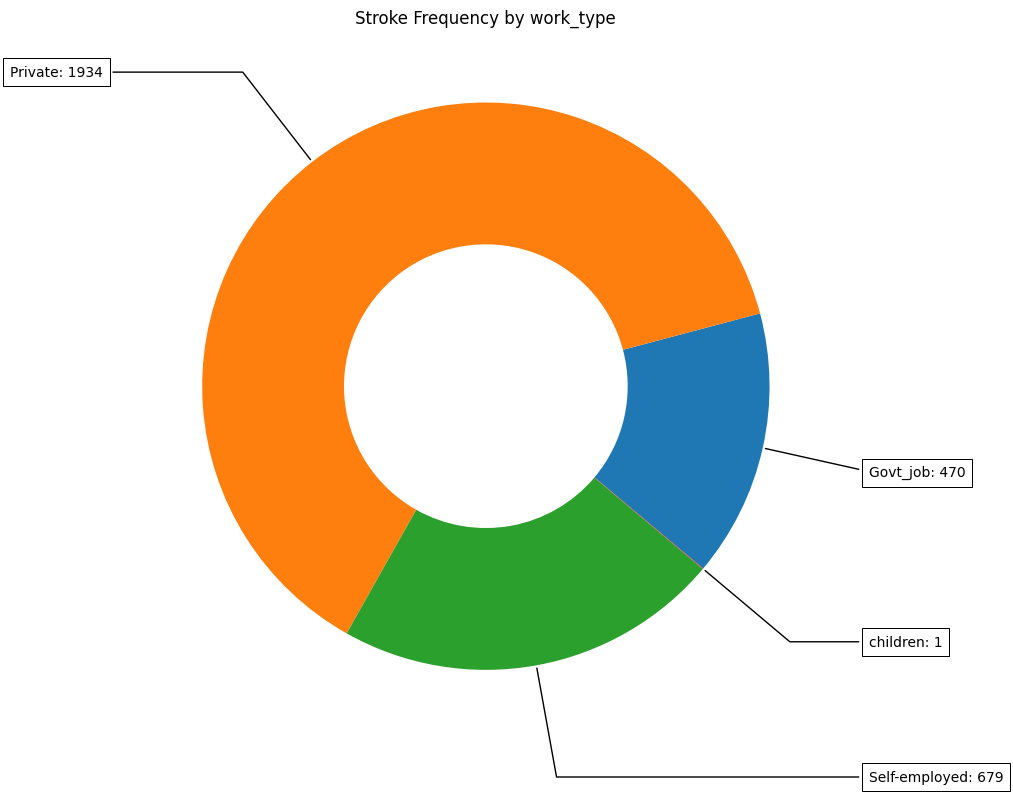


Stroke Frequency by Residence_type:


stroke,0.0,1.0
Residence_type,,
Rural,1062,456
Urban,1083,483


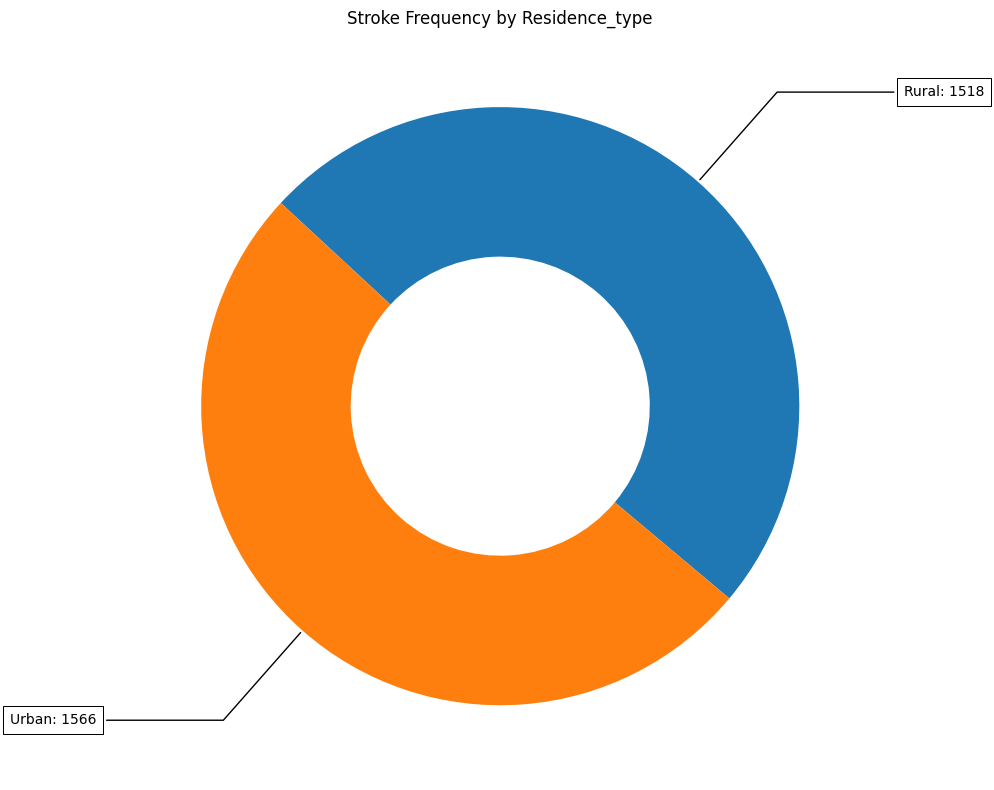


Stroke Frequency by smoking_status:


stroke,0.0,1.0
smoking_status,,
formerly smoked,531,280
never smoked,1105,492
smokes,509,167


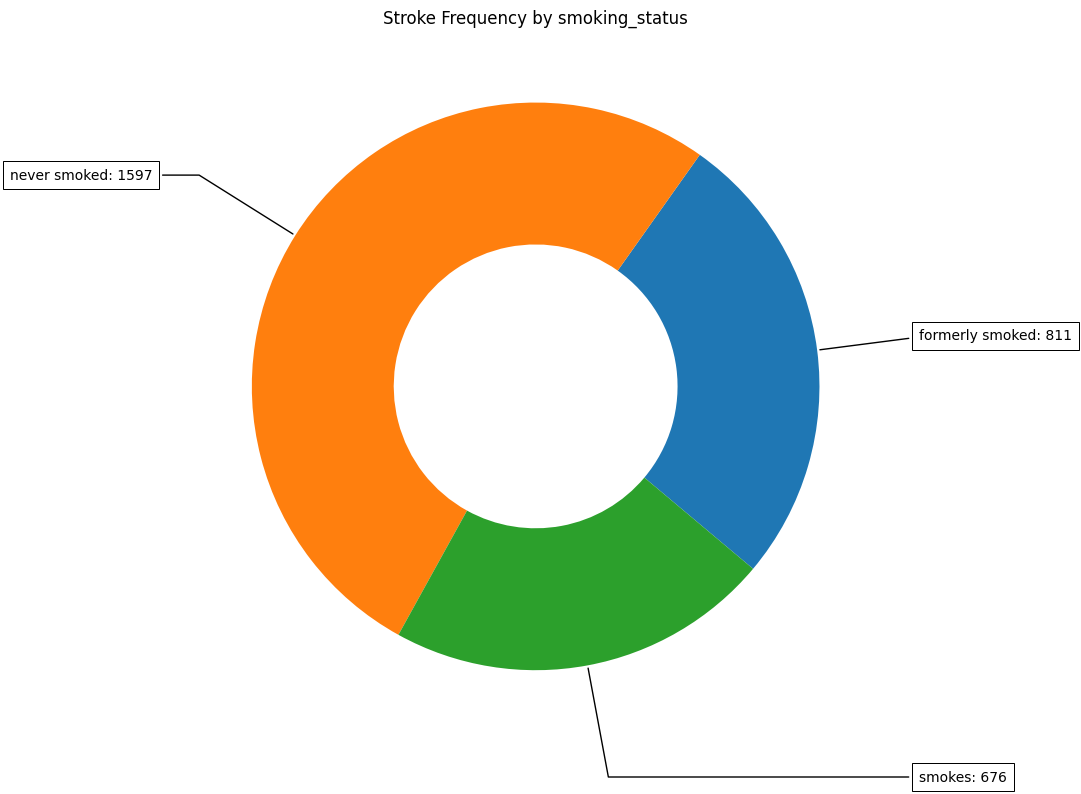


Stroke Frequency by hypertension:


stroke,0.0,1.0
hypertension,,
0,1898,692
1,247,247


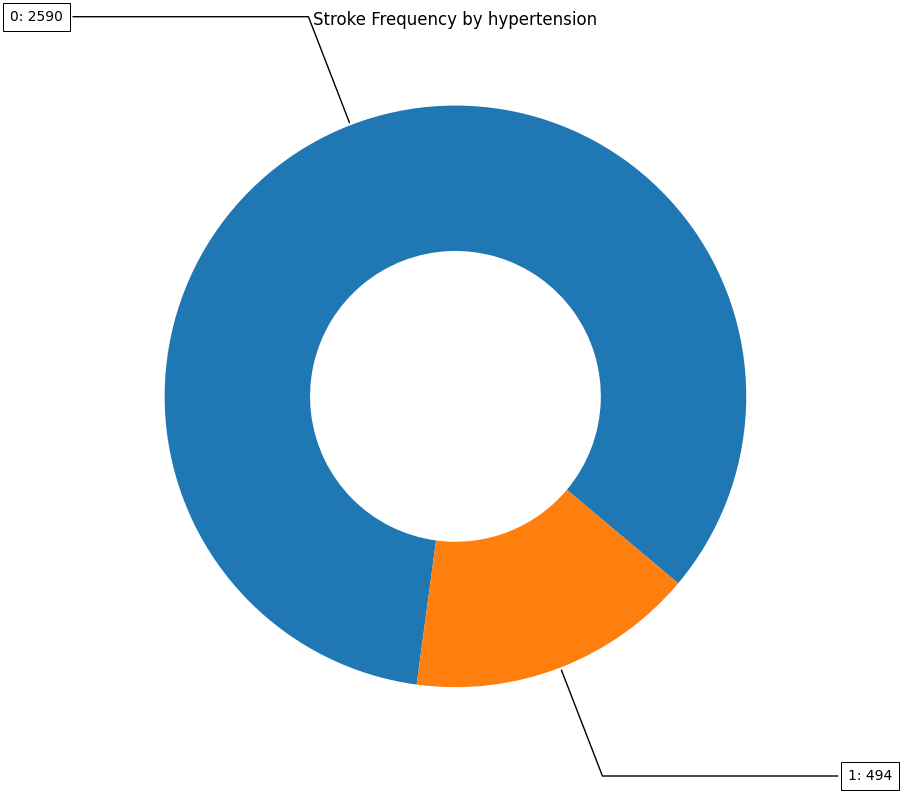

In [70]:
demographic_cols = [
    "gender",
    "ever_married",
    "work_type",
    "Residence_type",
    "smoking_status",
    "hypertension",
]

for col in demographic_cols:
    print(f"\nStroke Frequency by {col}:")
    crosstab = pd.crosstab(df[col], df["stroke"])
    display(crosstab)

    # Create a donut chart
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(aspect="equal"))

    # Get the data for the donut chart
    data = crosstab.sum(axis=1).values
    labels = crosstab.index

    # Create the donut chart
    wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

    bbox_props = dict(boxstyle="square,pad=0.5", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"), bbox=bbox_props, zorder=0, va="center")

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1) / 2.0 + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = f"angle,angleA=0,angleB={ang}"
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(
            # Use labels[i] instead of demographic_cols[i]
            f"{labels[i]}: {data[i]}",
            xy=(x, y),
            xytext=(1.35 * np.sign(x), 1.4 * y),
            horizontalalignment=horizontalalignment,
            **kw,
        )

    # Set the title
    ax.set_title(f"Stroke Frequency by {col}")

    # Show the plot
    plt.tight_layout()
    plt.show()

#### Outlier Detection and Handling

In [71]:
def detect_and_handle_outliers(df, column):
    # Store original values for comparison
    original_values = df[column].copy()

    # Calculate bounds
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f"Number of outliers in {column}: {len(outliers)}")

    # Cap outliers
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])

    # Compare before and after statistics
    print(f"\nStatistics for {column} before vs after handling outliers:")
    compare_stats = pd.DataFrame(
        {"Before": original_values.describe(), "After": df[column].describe()}
    )
    print(compare_stats)

    if column in ["avg_glucose_level", "bmi"]:
        # Create better-looking visualizations with side-by-side plots
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))

        # Box plots - Before
        sns.boxplot(x=original_values, color="skyblue", ax=axes[0, 0])
        axes[0, 0].set_title(f"Box Plot: {column} (Before)", fontsize=12)
        axes[0, 0].set_xlabel(f"{column} values")

        # Box plots - After
        sns.boxplot(x=df[column], color="lightgreen", ax=axes[0, 1])
        axes[0, 1].set_title(f"Box Plot: {column} (After)", fontsize=12)
        axes[0, 1].set_xlabel(f"{column} values")

        # Histograms - Before
        sns.histplot(original_values, kde=True, color="skyblue", ax=axes[1, 0])
        axes[1, 0].set_title(f"Distribution: {column} (Before)", fontsize=12)
        axes[1, 0].set_xlabel(f"{column} values")

        # Histograms - After
        sns.histplot(df[column], kde=True, color="lightgreen", ax=axes[1, 1])
        axes[1, 1].set_title(f"Distribution: {column} (After)", fontsize=12)
        axes[1, 1].set_xlabel(f"{column} values")

        plt.tight_layout()
        plt.show()

    return df

Number of outliers in age: 0

Statistics for age before vs after handling outliers:
            Before        After
count  3084.000000  3084.000000
mean     55.045396    55.045396
std      17.010230    17.010230
min      14.000000    14.000000
25%      42.000000    42.000000
50%      54.000000    54.000000
75%      71.000000    71.000000
max      82.000000    82.000000
Number of outliers in avg_glucose_level: 407

Statistics for avg_glucose_level before vs after handling outliers:
            Before        After
count  3084.000000  3084.000000
mean    113.434698   110.460725
std      51.756471    45.386868
min      55.220000    55.220000
25%      77.917500    77.917500
50%      94.185000    94.185000
75%     126.340000   126.340000
max     271.740000   198.973750


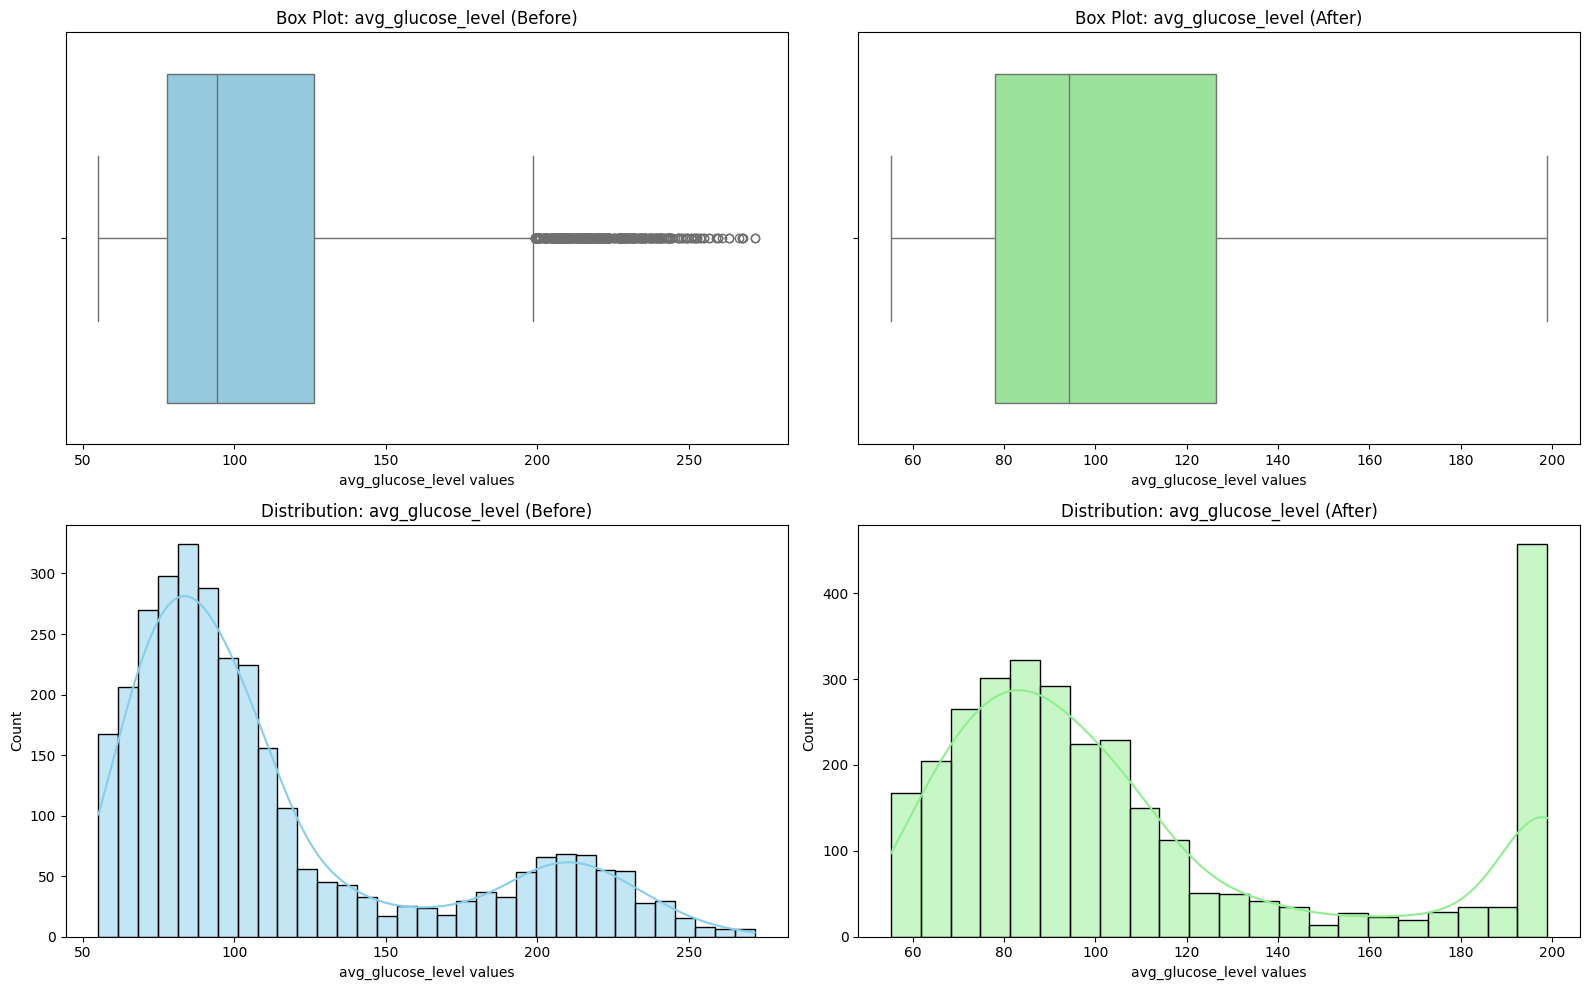

Number of outliers in bmi: 6

Statistics for bmi before vs after handling outliers:
            Before        After
count  3084.000000  3084.000000
mean     29.331550    29.332652
std       5.144821     5.141806
min      14.300000    15.750000
25%      25.800000    25.800000
50%      29.000000    29.000000
75%      32.500000    32.500000
max      41.900000    41.900000


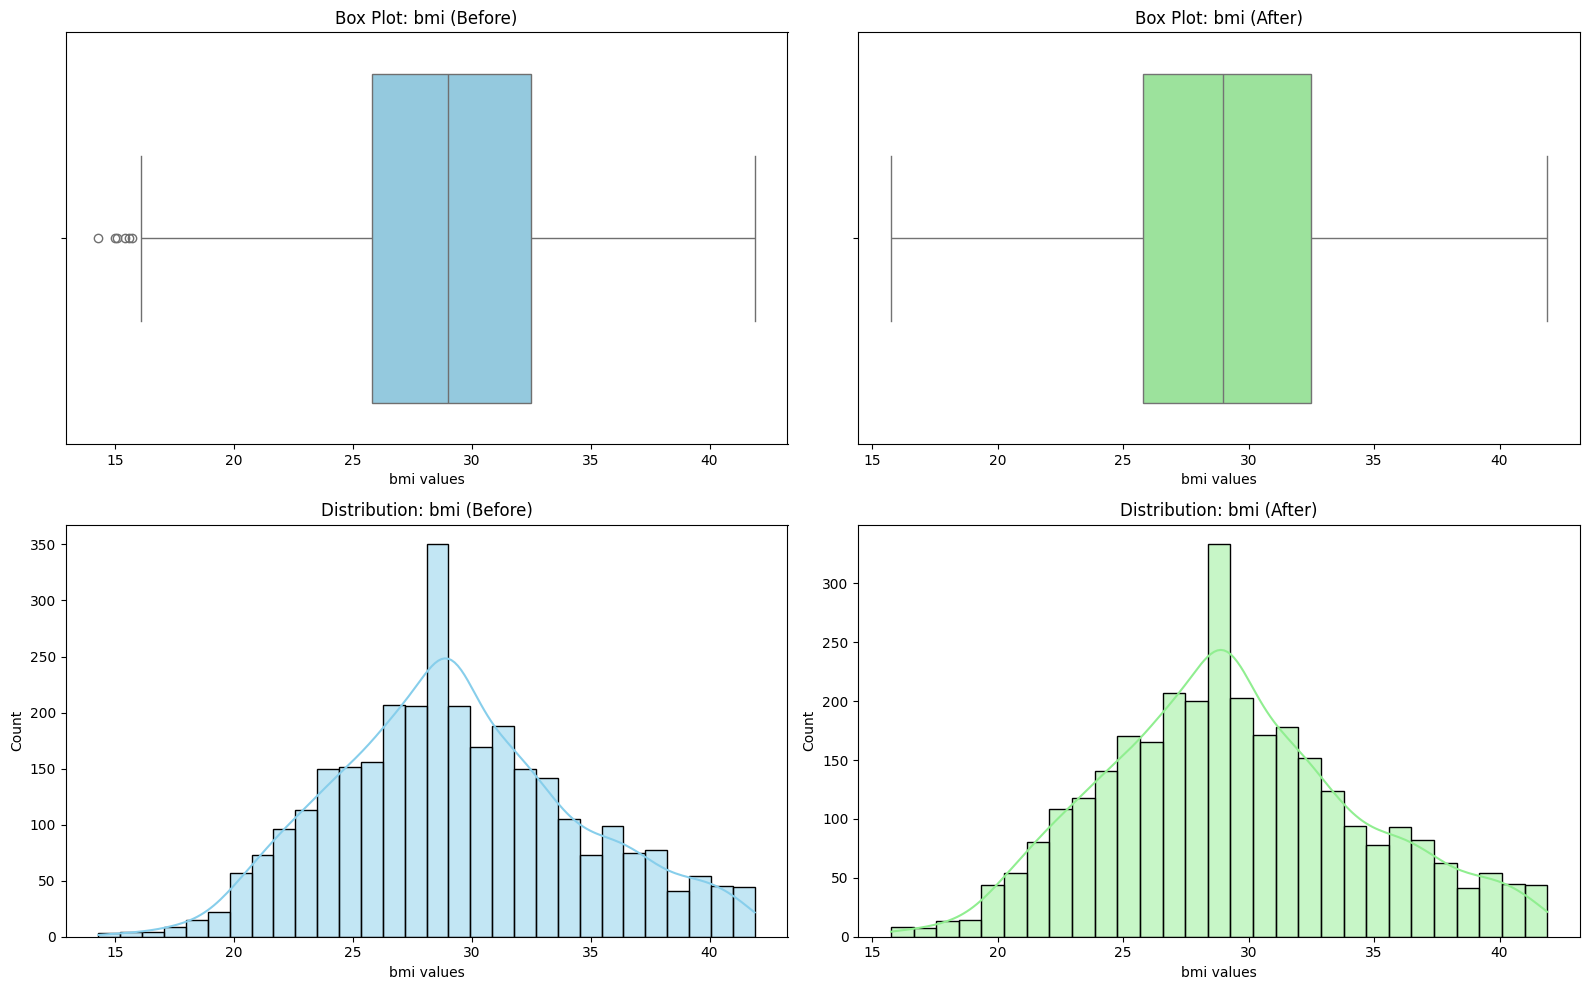

In [72]:
for col in numerical_cols:
    df = detect_and_handle_outliers(df, col)

In [73]:
object_columns = df.select_dtypes(include=["object"]).columns.tolist()
print(f"\nColumns with object dtype: {object_columns}")


Columns with object dtype: ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']


In [74]:
binary_columns = []
for col in df.columns:
    if df[col].dtype == "object":
        unique_vals = df[col].unique()
        if len(unique_vals) == 2 and set(unique_vals) == {"Yes", "No"}:
            binary_columns.append(col)
            df[col] = df[col].map({"Yes": 1, "No": 0})

In [75]:
le_dict = {}
for col in object_columns:
    if col not in binary_columns:  # Skip already converted binary columns
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        le_dict[col] = le  # Save encoder for future reference
        print(f"Encoded {col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")

Encoded gender: {'Female': np.int64(0), 'Male': np.int64(1)}
Encoded work_type: {'Govt_job': np.int64(0), 'Private': np.int64(1), 'Self-employed': np.int64(2), 'children': np.int64(3)}
Encoded Residence_type: {'Rural': np.int64(0), 'Urban': np.int64(1)}
Encoded smoking_status: {'formerly smoked': np.int64(0), 'never smoked': np.int64(1), 'smokes': np.int64(2)}


In [76]:
for col in binary_columns:
    if col not in categorical_cols and col != "stroke":
        categorical_cols.append(col)

In [77]:
# Convert categorical variables to numerical using Label Encoding
print("\n--- Converting Categorical Data to Numerical ---")
le_dict = {}



--- Converting Categorical Data to Numerical ---


In [78]:
for col in categorical_cols:
    if df[col].dtype == "object":  # Only encode columns that are still objects
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        le_dict[col] = le  # Save encoder for future reference
        print(f"Encoded {col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")


In [79]:
remaining_objects = df.select_dtypes(include=["object"]).columns.tolist()
if remaining_objects:
    print(
        f"\nWARNING: Still have object columns that need conversion: {remaining_objects}"
    )
    for col in remaining_objects:
        print(f"Values in {col}: {df[col].unique()}")
        if col != "stroke":  # Don't convert the target if it's already numeric
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
            print(f"Encoded {col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")

In [80]:
print("Inverse of Null Accuracy: ", 249 / (249 + 4861))
print("Null Accuracy: ", 4861 / (4861 + 249))

Inverse of Null Accuracy:  0.0487279843444227
Null Accuracy:  0.9512720156555773


In [81]:
df = df.apply(pd.to_numeric, errors="coerce")

In [82]:
if df.isnull().sum().sum() > 0:
    print(
        "\nWARNING: NaN values found after conversion. Filling with appropriate values."
    )
    df = df.fillna(df.mean())

In [83]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(df.drop("stroke", axis=1), df["stroke"])
df_resampled = pd.DataFrame(X_resampled, columns=df.drop("stroke", axis=1).columns)
df_resampled["stroke"] = y_resampled

In [84]:
scaler = StandardScaler()
numerical_cols = ["age", "avg_glucose_level", "bmi"]
df_resampled[numerical_cols] = scaler.fit_transform(df_resampled[numerical_cols])


Correlation Matrix (After Resampling and Scaling):
                     gender       age  hypertension  heart_disease  \
gender             1.000000 -0.032262      0.031714       0.097800   
age               -0.032262  1.000000      0.183204       0.231225   
hypertension       0.031714  0.183204      1.000000       0.118385   
heart_disease      0.097800  0.231225      0.118385       1.000000   
ever_married       0.024050  0.210480      0.025263       0.026966   
work_type          0.006779  0.177536      0.058330       0.045889   
Residence_type     0.009860 -0.064409      0.014567       0.008857   
avg_glucose_level  0.008754  0.212492      0.129472       0.195501   
bmi                0.078834 -0.047904      0.087148       0.021409   
smoking_status     0.005206 -0.237453      0.008018       0.014011   
stroke            -0.070594  0.584326      0.077423       0.140059   

                   ever_married  work_type  Residence_type  avg_glucose_level  \
gender                 0.0

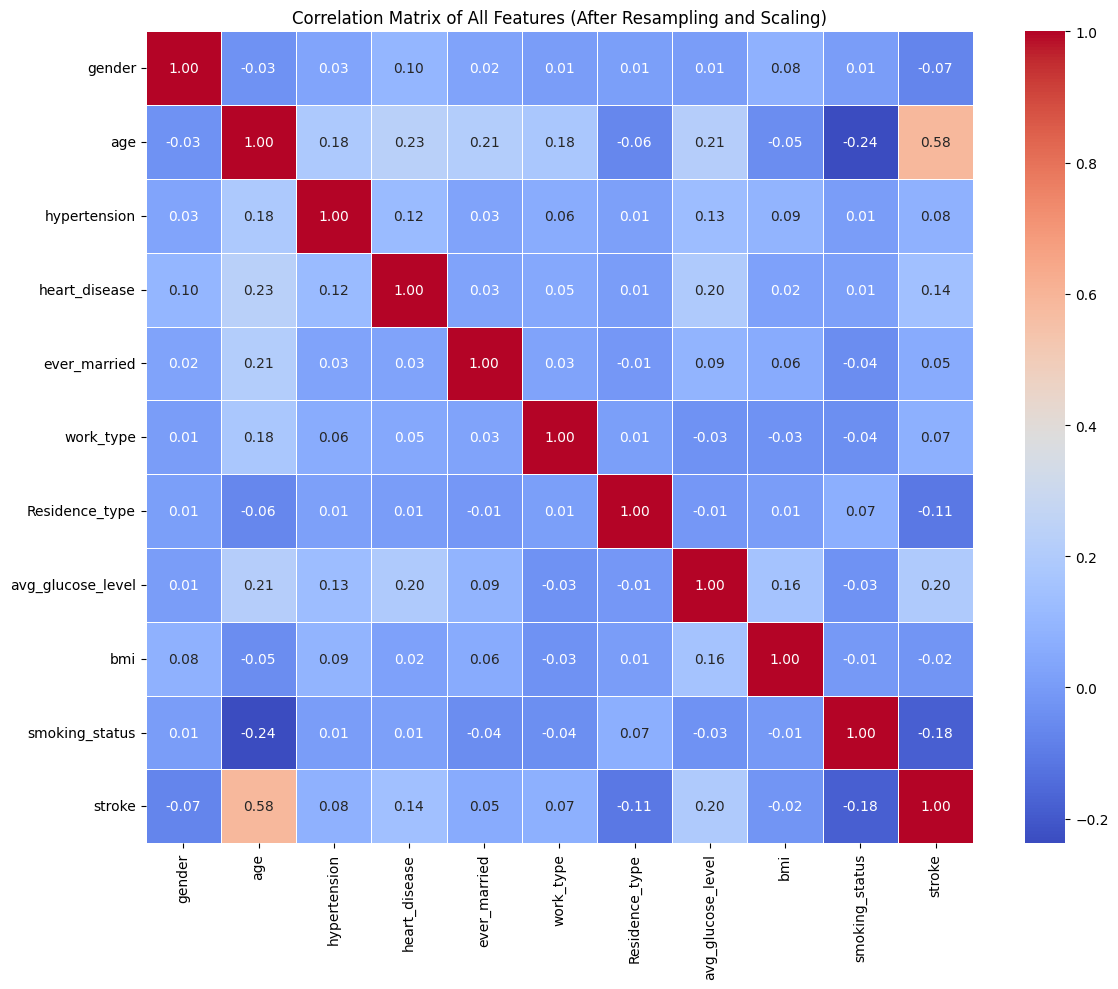


Feature Correlation with Target (stroke):
stroke               1.000000
age                  0.584326
avg_glucose_level    0.196559
heart_disease        0.140059
hypertension         0.077423
work_type            0.073250
ever_married         0.052943
bmi                 -0.023551
gender              -0.070594
Residence_type      -0.108212
smoking_status      -0.182665
Name: stroke, dtype: float64


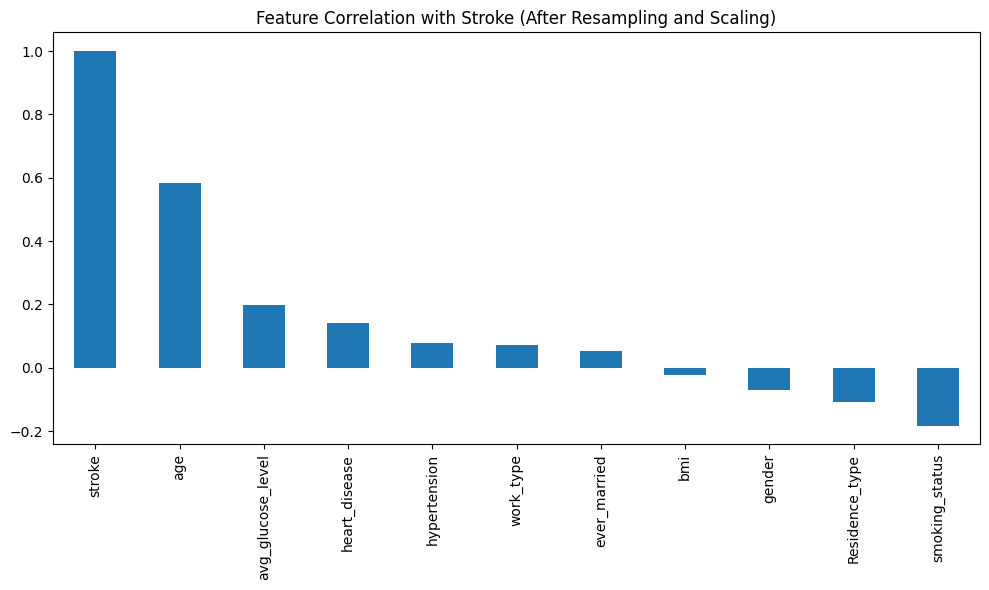

In [85]:
correlation_matrix = df_resampled.corr()
print("\nCorrelation Matrix (After Resampling and Scaling):")
print(correlation_matrix)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of All Features (After Resampling and Scaling)")
plt.tight_layout()
plt.show()

target_correlation = correlation_matrix["stroke"].sort_values(ascending=False)
print("\nFeature Correlation with Target (stroke):")
print(target_correlation)

plt.figure(figsize=(10, 6))
target_correlation.plot(kind="bar")
plt.title("Feature Correlation with Stroke (After Resampling and Scaling)")
plt.tight_layout()
plt.show()

In [86]:
print("\n--- Correlation Analysis ---")
correlation_matrix = df.corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)


--- Correlation Analysis ---

Correlation Matrix:
                     gender       age  hypertension  heart_disease  \
gender             1.000000  0.052534      0.017595       0.095954   
age                0.052534  1.000000      0.262639       0.307160   
hypertension       0.017595  0.262639      1.000000       0.114005   
heart_disease      0.095954  0.307160      0.114005       1.000000   
ever_married       0.037358  0.290471      0.040470       0.046234   
work_type         -0.003945  0.215360      0.064314       0.059967   
Residence_type    -0.017727 -0.001147     -0.015640      -0.003361   
avg_glucose_level  0.039411  0.229412      0.157401       0.188075   
bmi                0.091517 -0.016307      0.102357       0.009965   
smoking_status    -0.017969 -0.176124     -0.028545      -0.013954   
stroke             0.042850  0.525056      0.185560       0.243552   

                   ever_married  work_type  Residence_type  avg_glucose_level  \
gender                 0.03

In [87]:
target_correlation = correlation_matrix["stroke"].sort_values(ascending=True)
print("\nFeature Correlation with Target (stroke):")
print(target_correlation)


Feature Correlation with Target (stroke):
smoking_status      -0.073101
bmi                 -0.029037
Residence_type       0.008728
gender               0.042850
ever_married         0.096452
work_type            0.148154
hypertension         0.185560
avg_glucose_level    0.196370
heart_disease        0.243552
age                  0.525056
stroke               1.000000
Name: stroke, dtype: float64


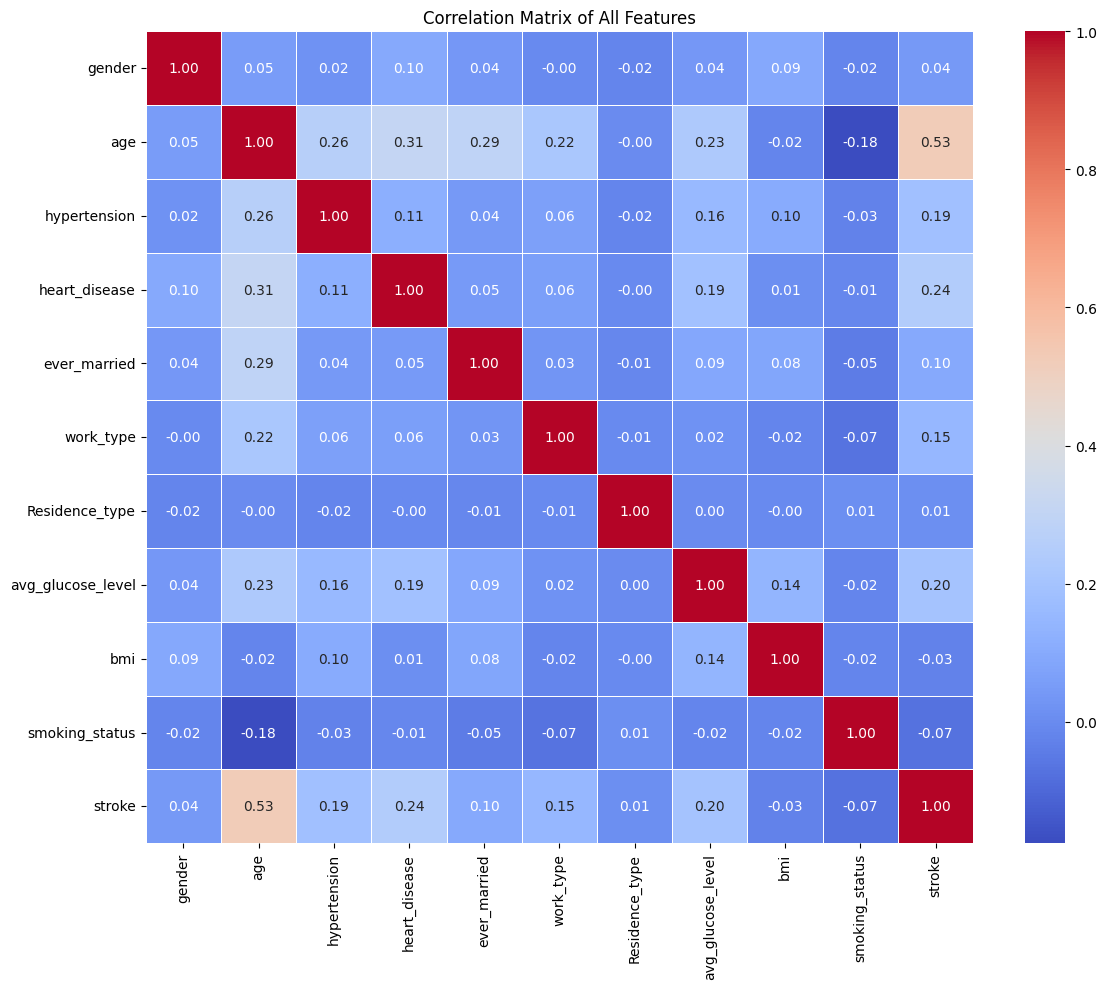

In [88]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of All Features")
plt.tight_layout()
plt.show()

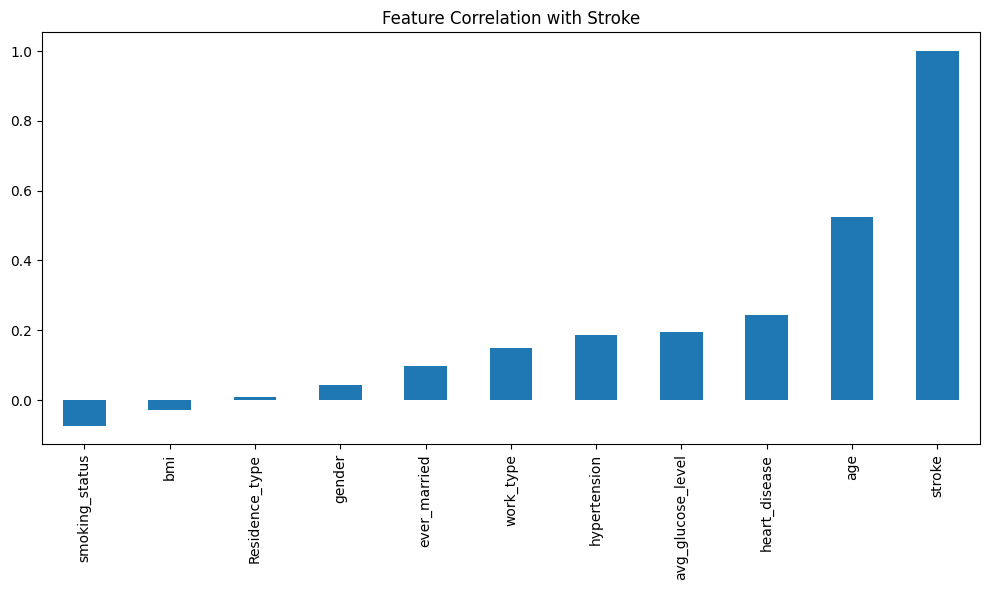

In [89]:
plt.figure(figsize=(10, 6))
target_correlation.plot(kind="bar")
plt.title("Feature Correlation with Stroke")
plt.tight_layout()
plt.show()

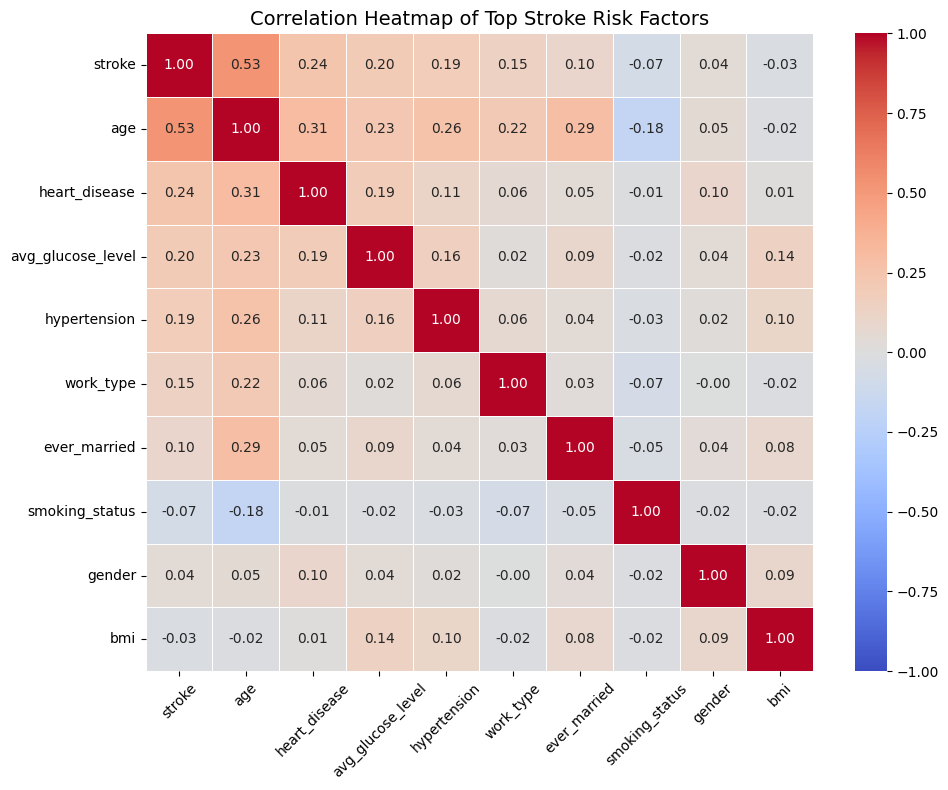

In [ ]:
# Select top correlated features
top_features = target_correlation.abs().sort_values(ascending=False).head(10).index

plt.figure(figsize=(10, 8))
sns.heatmap(
    df[top_features].corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5,
    vmin=-1,
    vmax=1,
)
plt.title("Correlation Heatmap of Top Stroke Risk Factors", fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [91]:
# Recalculate correlation after feature engineering
print("\n--- Correlation After Feature Engineering ---")
correlation_after_fe = df.corr()["stroke"].sort_values(ascending=False)
print(correlation_after_fe)


--- Correlation After Feature Engineering ---
stroke               1.000000
age                  0.525056
heart_disease        0.243552
avg_glucose_level    0.196370
hypertension         0.185560
work_type            0.148154
ever_married         0.096452
gender               0.042850
Residence_type       0.008728
bmi                 -0.029037
smoking_status      -0.073101
Name: stroke, dtype: float64


In [92]:
# Find features with correlation greater than 0.8
columns_to_drop = ["Residence_type", "ever_married", "work_type"]
# Drop highly correlated features
df.drop(columns_to_drop, axis=1, inplace=True)
print(f"\nDropped columns due to high correlation: {columns_to_drop}")


Dropped columns due to high correlation: ['Residence_type', 'ever_married', 'work_type']


In [93]:
# Choose which scaling method to use
scaling_method = "minmax"  # Options: 'standard', 'minmax'
scaling_range = "single"  # Options: 'single', 'double'

if scaling_method == "standard":
    scaler = StandardScaler()
elif scaling_method == "minmax":
    if scaling_range == "single":
        scaler = MinMaxScaler(feature_range=(0, 9))
    else:  # double digit
        scaler = MinMaxScaler(feature_range=(0, 99))

# Apply scaling to numerical features
scaled_features = scaler.fit_transform(df[numerical_cols])
df[numerical_cols] = scaled_features
# print(df)

In [94]:
X = df.drop("stroke", axis=1)
y = df["stroke"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape

(2467, 7)

#### Advanced Resampling with imbalanced-learn
##### Evaluate different resampling strategies
##### Define resampling methods to test

In [95]:
resampling_methods = {
    "No resampling": None,
    "SMOTE": SMOTE(random_state=42),
    "BorderlineSMOTE": BorderlineSMOTE(random_state=42),
    "ADASYN": ADASYN(random_state=42),
    "RandomUnderSampler": RandomUnderSampler(random_state=42),
    "ClusterCentroids": ClusterCentroids(random_state=42),
    "SMOTETomek": SMOTETomek(random_state=42),
    "SMOTEENN": SMOTEENN(random_state=42),
}

##### Test each resampling method with a baseline model

In [96]:
baseline_model = RandomForestClassifier(n_estimators=100, random_state=42)
resampling_results = []

for name, method in resampling_methods.items():
    print(f"\nEvaluating resampling method: {name}")

    # Create a resampling pipeline if method is not None
    if method is not None:
        pipeline = ImbPipeline([("resampler", method), ("classifier", baseline_model)])

        # Fit the pipeline
        pipeline.fit(X_train, y_train)

        # Make predictions
        y_pred = pipeline.predict(X_test)

        # Get class distribution after resampling
        X_resampled, y_resampled = method.fit_resample(X_train, y_train)
        pos_count = sum(y_resampled == 1)
        neg_count = sum(y_resampled == 0)

    else:
        # No resampling
        baseline_model.fit(X_train, y_train)
        y_pred = baseline_model.predict(X_test)
        pos_count = sum(y_train == 1)
        neg_count = sum(y_train == 0)

    # Calculate metrics
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    print(
        f"Class distribution after resampling - Positive: {pos_count}, Negative: {neg_count}, Ratio: 1:{neg_count / pos_count:.1f}"
    )
    print(f"F1 Score: {f1:.4f}, Recall: {recall:.4f}")

    resampling_results.append(
        {
            "Method": name,
            "F1 Score": f1,
            "Recall": recall,
            "Pos Count": pos_count,
            "Neg Count": neg_count,
            "Ratio": neg_count / pos_count,
        }
    )


Evaluating resampling method: No resampling
Class distribution after resampling - Positive: 751, Negative: 1716, Ratio: 1:2.3
F1 Score: 0.7652, Recall: 0.7713

Evaluating resampling method: SMOTE
Class distribution after resampling - Positive: 1716, Negative: 1716, Ratio: 1:1.0
F1 Score: 0.7598, Recall: 0.8245

Evaluating resampling method: BorderlineSMOTE
Class distribution after resampling - Positive: 1716, Negative: 1716, Ratio: 1:1.0
F1 Score: 0.7346, Recall: 0.8245

Evaluating resampling method: ADASYN
Class distribution after resampling - Positive: 1772, Negative: 1716, Ratio: 1:1.0
F1 Score: 0.7446, Recall: 0.8298

Evaluating resampling method: RandomUnderSampler
Class distribution after resampling - Positive: 751, Negative: 751, Ratio: 1:1.0
F1 Score: 0.7402, Recall: 0.8564

Evaluating resampling method: ClusterCentroids
Class distribution after resampling - Positive: 751, Negative: 751, Ratio: 1:1.0
F1 Score: 0.7570, Recall: 0.8617

Evaluating resampling method: SMOTETomek
Cl


Resampling method comparison:
               Method  F1 Score    Recall  Pos Count  Neg Count     Ratio
0       No resampling  0.765172  0.771277        751       1716  2.284953
1               SMOTE  0.759804  0.824468       1716       1716  1.000000
2     BorderlineSMOTE  0.734597  0.824468       1716       1716  1.000000
3              ADASYN  0.744630  0.829787       1772       1716  0.968397
4  RandomUnderSampler  0.740230  0.856383        751        751  1.000000
5    ClusterCentroids  0.757009  0.861702        751        751  1.000000
6          SMOTETomek  0.737101  0.797872       1661       1661  1.000000
7            SMOTEENN  0.736842  0.856383       1252       1056  0.843450


<Figure size 1200x600 with 0 Axes>

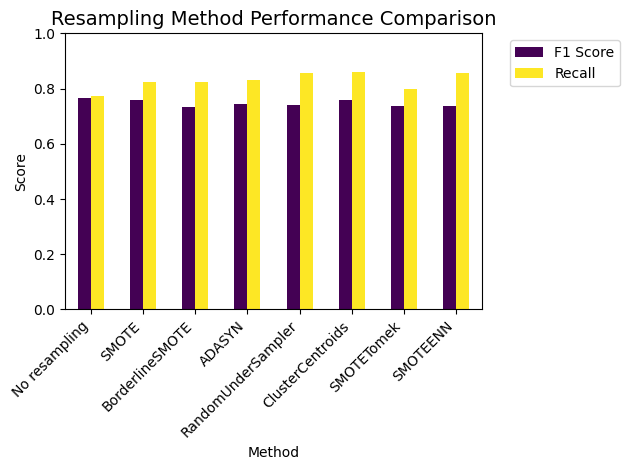


Best resampling method: No resampling

Using original imbalanced data (no resampling applied)


In [97]:
# Convert results to DataFrame and find best method
resampling_df = pd.DataFrame(resampling_results)
print("\nResampling method comparison:")
print(resampling_df)
# Visualize comparison
plt.figure(figsize=(12, 6))
metrics_to_plot = ["F1 Score", "Recall"]
resampling_df.set_index("Method")[metrics_to_plot].plot(kind="bar", colormap="viridis")
plt.title("Resampling Method Performance Comparison", fontsize=14)
plt.ylabel("Score")
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()
# Select best resampling method based on F1 score
best_resampling_method_name = resampling_df.loc[
    resampling_df["F1 Score"].idxmax(), "Method"
]
best_resampling_method = resampling_methods[best_resampling_method_name]
print(f"\nBest resampling method: {best_resampling_method_name}")

# Apply the best resampling method
if best_resampling_method is not None:
    X_resampled, y_resampled = best_resampling_method.fit_resample(X_train, y_train)
    # Visualize new class distribution
    plt.figure(figsize=(8, 5))
    sns.countplot(x=y_resampled, palette=["#2ecc71", "#e74c3c"], hue=y_resampled)
    plt.title(f"Class Distribution After {best_resampling_method_name}", fontsize=14)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.xticks([0, 1], ["Negative (0)", "Positive (1)"])

    # Add count labels
    for p in plt.gca().patches:
        plt.gca().annotate(
            f"{p.get_height():,}",
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="center",
            xytext=(0, 10),
            textcoords="offset points",
        )

    plt.show()

    print("Resampled class distribution:")
    print(f"- Positive cases (1): {sum(y_resampled == 1):,}")
    print(f"- Negative cases (0): {sum(y_resampled == 0):,}")
    print(f"- Ratio: {sum(y_resampled == 1) / sum(y_resampled == 0):.2f}:1")
else:
    X_resampled, y_resampled = X_train, y_train
    print("\nUsing original imbalanced data (no resampling applied)")

In [98]:
# 3.1 Define parameter grids for each model
param_grids = {
    "KNN": {
        "n_neighbors": [3, 5, 7, 9, 11, 13],
        "weights": ["uniform", "distance"],
        "metric": ["euclidean", "manhattan", "minkowski"],
        "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
    },
    "RandomForest": {
        "n_estimators": [100, 200, 300],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "class_weight": ["balanced", "balanced_subsample", None],
    },
    "DecisionTree": {
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "criterion": ["gini", "entropy"],
        "class_weight": ["balanced", None],
    },
    "LogisticRegression": {
        "C": [0.1, 1, 10, 100],
        "solver": ["liblinear", "saga"],  # removed lbfgs since we want l1
        "penalty": ["l1", "l2"],  # removed None and elasticnet
        "class_weight": ["balanced", None],
        "max_iter": [100, 500, 1000],
    },
}

In [99]:
models = {
    "KNN": KNeighborsClassifier(),
    "RandomForest": RandomForestClassifier(random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(random_state=42),
}

best_models = {}
best_scores = {}

In [100]:
for name, model in models.items():
    print(f"\nTraining and tuning {name}...")

    # Use RandomizedSearchCV for faster hyperparameter tuning
    search = RandomizedSearchCV(
        model,
        param_grids[name],
        n_iter=20,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring="f1",
        n_jobs=-1,
        random_state=42,
    )

    # Fit the model
    search.fit(X_resampled, y_resampled)

    # Save the best model
    best_models[name] = search.best_estimator_
    best_scores[name] = search.best_score_

    print(f"Best parameters: {search.best_params_}")
    print(f"Best cross-validation score: {search.best_score_:.4f}")



Training and tuning KNN...
Best parameters: {'weights': 'distance', 'n_neighbors': 11, 'metric': 'euclidean', 'algorithm': 'brute'}
Best cross-validation score: 0.6795

Training and tuning RandomForest...
Best parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None, 'class_weight': 'balanced'}
Best cross-validation score: 0.7249

Training and tuning DecisionTree...
Best parameters: {'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 10, 'criterion': 'gini', 'class_weight': 'balanced'}
Best cross-validation score: 0.6734

Training and tuning LogisticRegression...
Best parameters: {'solver': 'saga', 'penalty': 'l1', 'max_iter': 1000, 'class_weight': 'balanced', 'C': 1}
Best cross-validation score: 0.6911



KNN Results:
              precision    recall  f1-score   support

         0.0       0.88      0.87      0.87       429
         1.0       0.71      0.73      0.72       188

    accuracy                           0.83       617
   macro avg       0.79      0.80      0.80       617
weighted avg       0.83      0.83      0.83       617

Imbalanced Classification Report:
                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.88      0.87      0.73      0.87      0.80      0.64       429
        1.0       0.71      0.73      0.87      0.72      0.80      0.63       188

avg / total       0.83      0.83      0.77      0.83      0.80      0.64       617



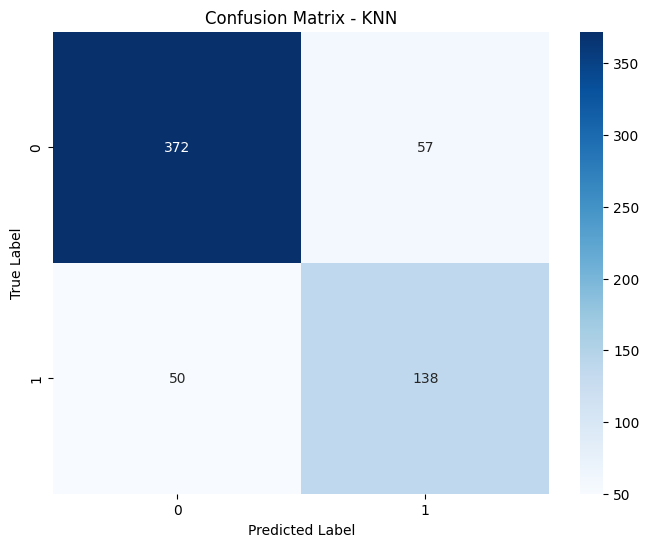

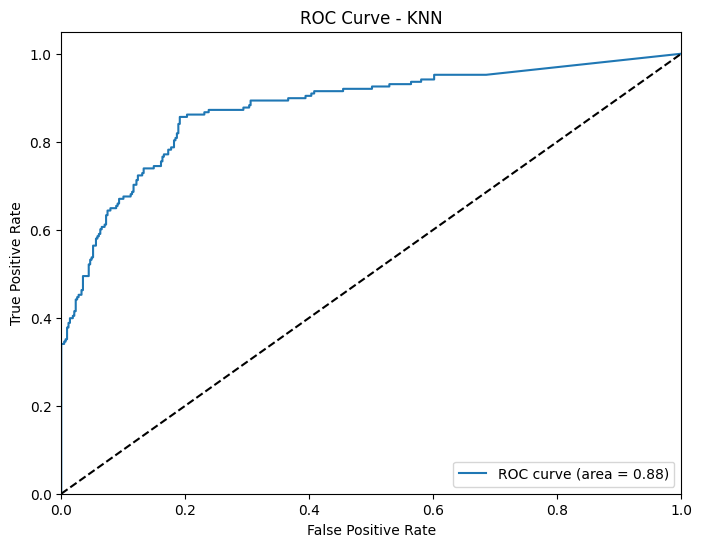

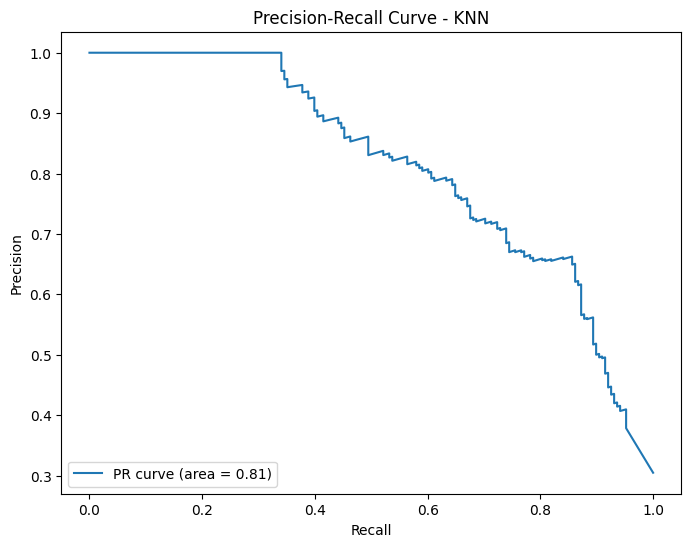


RandomForest Results:
              precision    recall  f1-score   support

         0.0       0.90      0.86      0.88       429
         1.0       0.71      0.79      0.75       188

    accuracy                           0.84       617
   macro avg       0.81      0.83      0.81       617
weighted avg       0.84      0.84      0.84       617

Imbalanced Classification Report:
                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.90      0.86      0.79      0.88      0.82      0.68       429
        1.0       0.71      0.79      0.86      0.75      0.82      0.68       188

avg / total       0.84      0.84      0.81      0.84      0.82      0.68       617



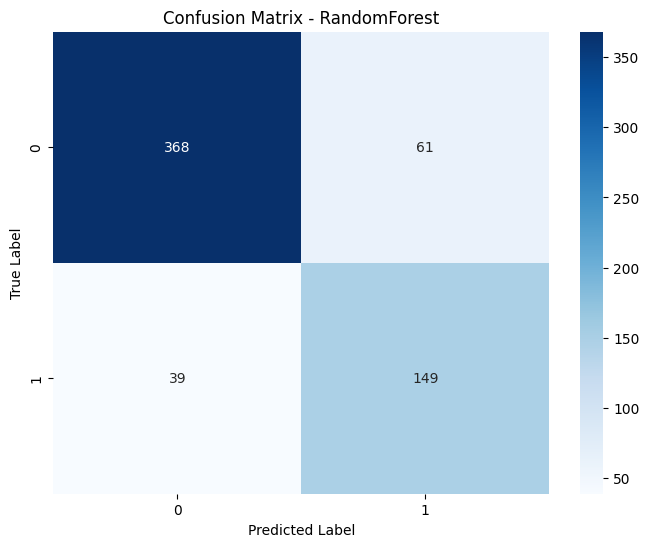

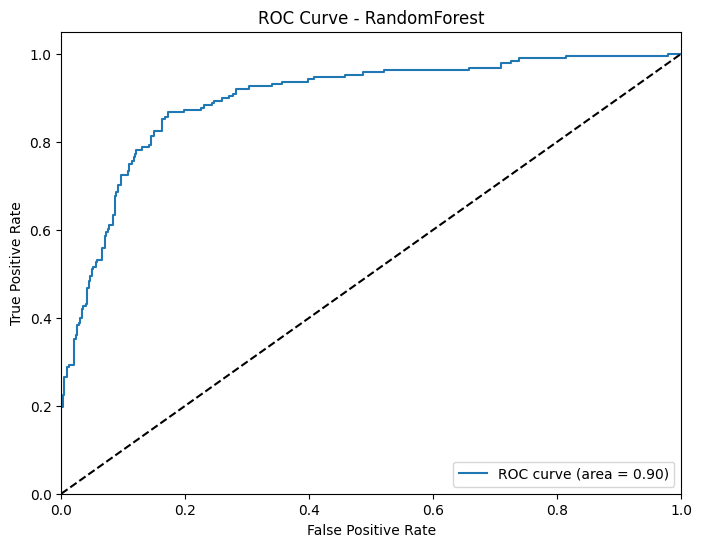

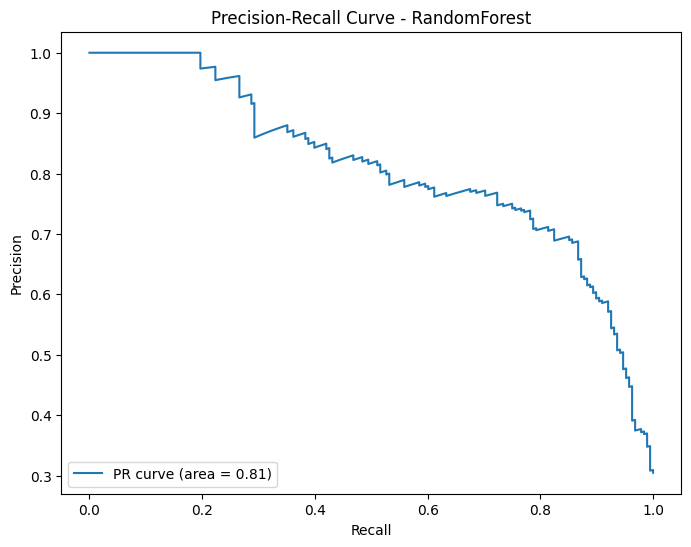


DecisionTree Results:
              precision    recall  f1-score   support

         0.0       0.88      0.79      0.83       429
         1.0       0.61      0.74      0.67       188

    accuracy                           0.77       617
   macro avg       0.74      0.77      0.75       617
weighted avg       0.79      0.77      0.78       617

Imbalanced Classification Report:
                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.88      0.79      0.74      0.83      0.77      0.59       429
        1.0       0.61      0.74      0.79      0.67      0.77      0.58       188

avg / total       0.79      0.77      0.76      0.78      0.77      0.59       617



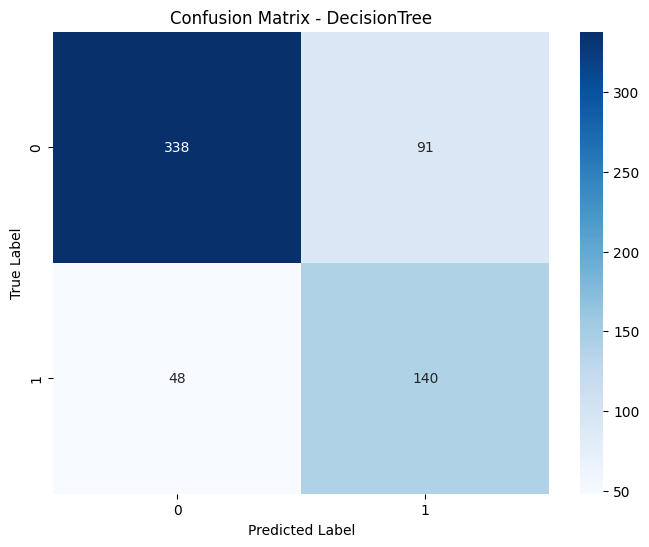

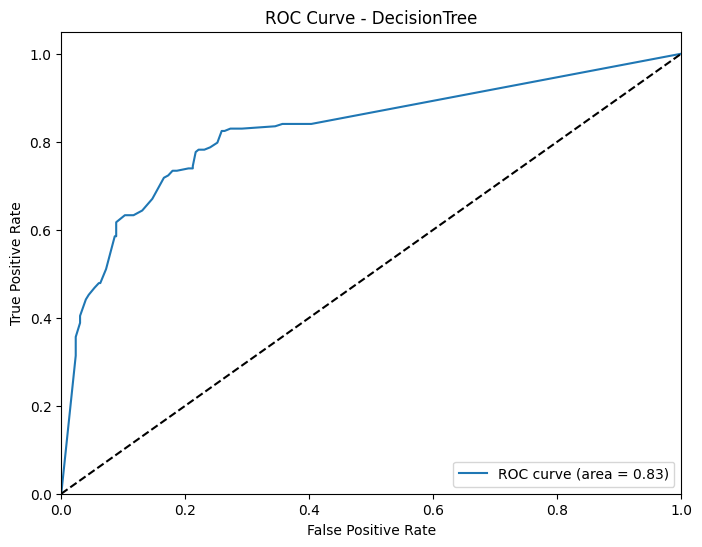

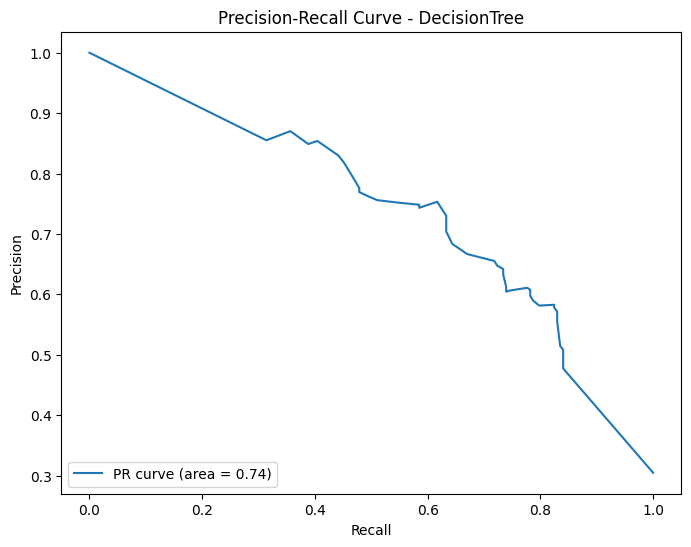


LogisticRegression Results:
              precision    recall  f1-score   support

         0.0       0.91      0.83      0.87       429
         1.0       0.67      0.81      0.74       188

    accuracy                           0.82       617
   macro avg       0.79      0.82      0.80       617
weighted avg       0.84      0.82      0.83       617

Imbalanced Classification Report:
                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.91      0.83      0.81      0.87      0.82      0.67       429
        1.0       0.67      0.81      0.83      0.74      0.82      0.67       188

avg / total       0.84      0.82      0.82      0.83      0.82      0.67       617



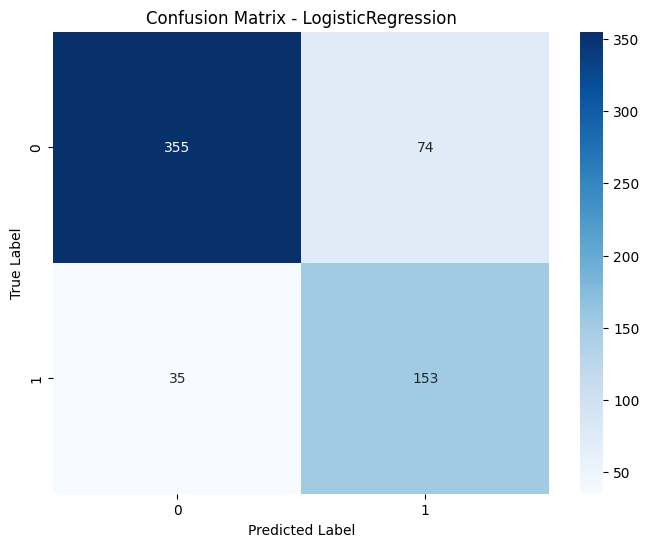

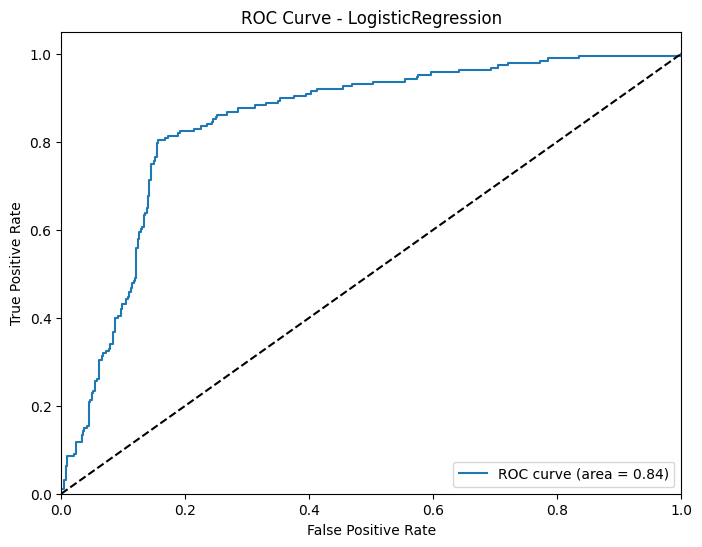

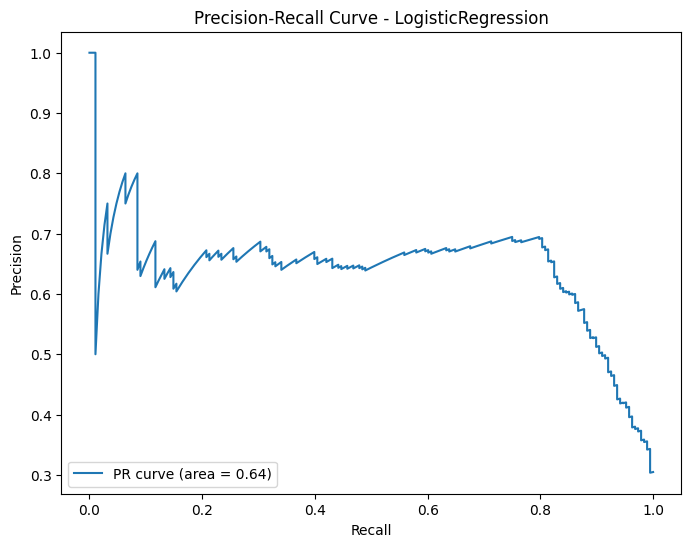

In [101]:
model_results = []

for name, model in best_models.items():
    # Make predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precison = precision_score(y_test, y_pred)
    # Calculate ROC-AUC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Calculate PR-AUC
    precision, recall_curve, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall_curve, precision)

    model_results.append(
        {
            "Model": name,
            "Accuracy": accuracy,
            "F1 Score": f1,
            "Precision": precison,
            "Recall": recall,
            "ROC-AUC": roc_auc,
            "PR-AUC": pr_auc,
        }
    )

    # Print classification report
    print(f"\n{name} Results:")
    print(classification_report(y_test, y_pred))

    # Print imbalanced classification report
    print("Imbalanced Classification Report:")
    print(classification_report_imbalanced(y_test, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {name}")
    plt.legend(loc="lower right")
    plt.show()

    # Plot Precision-Recall curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall_curve, precision, label=f"PR curve (area = {pr_auc:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve - {name}")
    plt.legend(loc="lower left")
    plt.show()


=== Training Ensemble Model ===

Voting Classifier Results:
              precision    recall  f1-score   support

         0.0       0.91      0.83      0.87       429
         1.0       0.68      0.80      0.74       188

    accuracy                           0.82       617
   macro avg       0.79      0.82      0.80       617
weighted avg       0.84      0.82      0.83       617

Imbalanced Classification Report:
                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.91      0.83      0.80      0.87      0.82      0.67       429
        1.0       0.68      0.80      0.83      0.74      0.82      0.67       188

avg / total       0.84      0.82      0.81      0.83      0.82      0.67       617



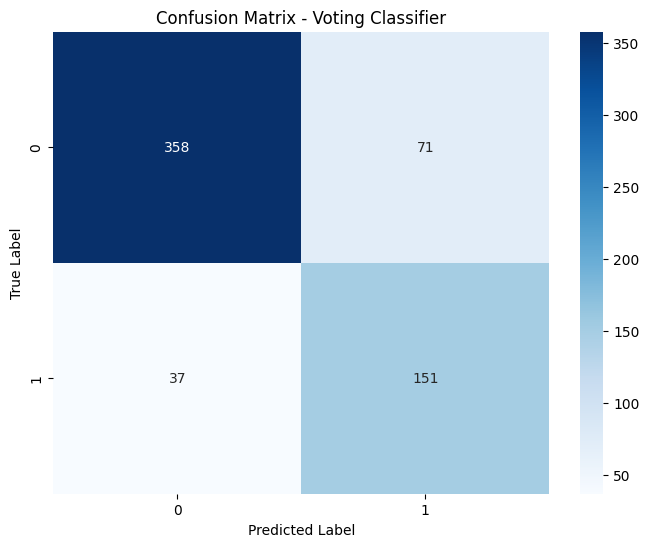

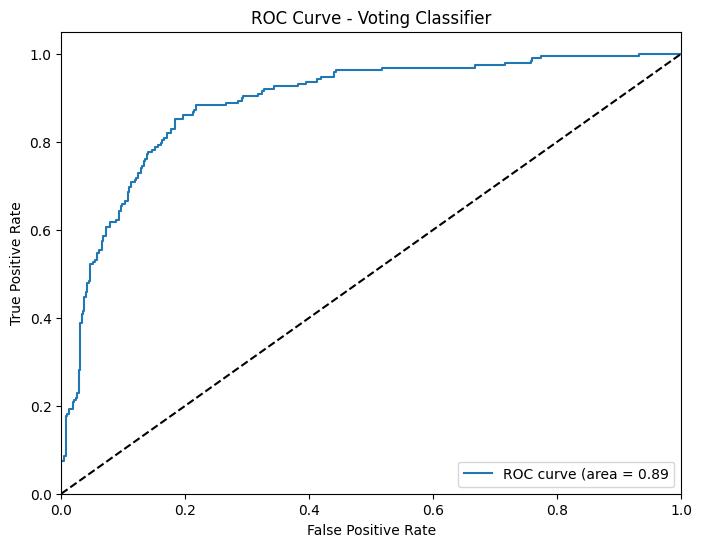

In [102]:
# =============================================
# Ensemble Model (Voting Classifier)
# =============================================
print("\n=== Training Ensemble Model ===")

# Create the voting classifier using the best models from previous steps
voting_clf = VotingClassifier(
    estimators=[
        ("rf", best_models["RandomForest"]),
        ("dt", best_models["DecisionTree"]),
        ("lr", best_models["LogisticRegression"]),
    ],
    voting="soft",  # Use soft voting for probability estimates
)

# Train the voting classifier
voting_clf.fit(X_resampled, y_resampled)

# Add to best_models dictionary for consistent evaluation
best_models["Voting"] = voting_clf

# Evaluate the ensemble model
y_pred = voting_clf.predict(X_test)
y_prob = voting_clf.predict_proba(X_test)[:, 1]

# Calculate metrics
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

# Calculate ROC-AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Calculate PR-AUC
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall_curve, precision_curve)

# Add to model results
model_results.append(
    {
        "Model": "Voting",
        "Accuracy": accuracy,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall,
        "ROC-AUC": roc_auc,
        "PR-AUC": pr_auc,
    }
)

# Print classification report
print("\nVoting Classifier Results:")
print(classification_report(y_test, y_pred))

# Print imbalanced classification report
print("Imbalanced Classification Report:")
print(classification_report_imbalanced(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Voting Classifier")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Voting Classifier")
plt.legend(loc="lower right")
plt.show()

In [103]:
print(precision_score(y_test, y_pred))

0.6801801801801802


In [104]:
model_results_df = pd.DataFrame(model_results)
print("\nModel Comparison:")
print(model_results_df)


Model Comparison:
                Model  Accuracy  F1 Score  Precision    Recall   ROC-AUC  \
0                 KNN  0.826580  0.720627   0.707692  0.734043  0.877604   
1        RandomForest  0.837925  0.748744   0.709524  0.792553  0.896742   
2        DecisionTree  0.774716  0.668258   0.606061  0.744681  0.825429   
3  LogisticRegression  0.823339  0.737349   0.674009  0.813830  0.844604   
4              Voting  0.824959  0.736585   0.680180  0.803191  0.888657   

     PR-AUC  
0  0.813464  
1  0.808737  
2  0.738544  
3  0.640000  
4  0.769469  



Model Performance Comparison:
                Model  Accuracy  F1 Score  Precision    Recall   ROC-AUC  \
0                 KNN  0.826580  0.720627   0.707692  0.734043  0.877604   
1        RandomForest  0.837925  0.748744   0.709524  0.792553  0.896742   
2        DecisionTree  0.774716  0.668258   0.606061  0.744681  0.825429   
3  LogisticRegression  0.823339  0.737349   0.674009  0.813830  0.844604   
4              Voting  0.824959  0.736585   0.680180  0.803191  0.888657   

     PR-AUC  
0  0.813464  
1  0.808737  
2  0.738544  
3  0.640000  
4  0.769469  


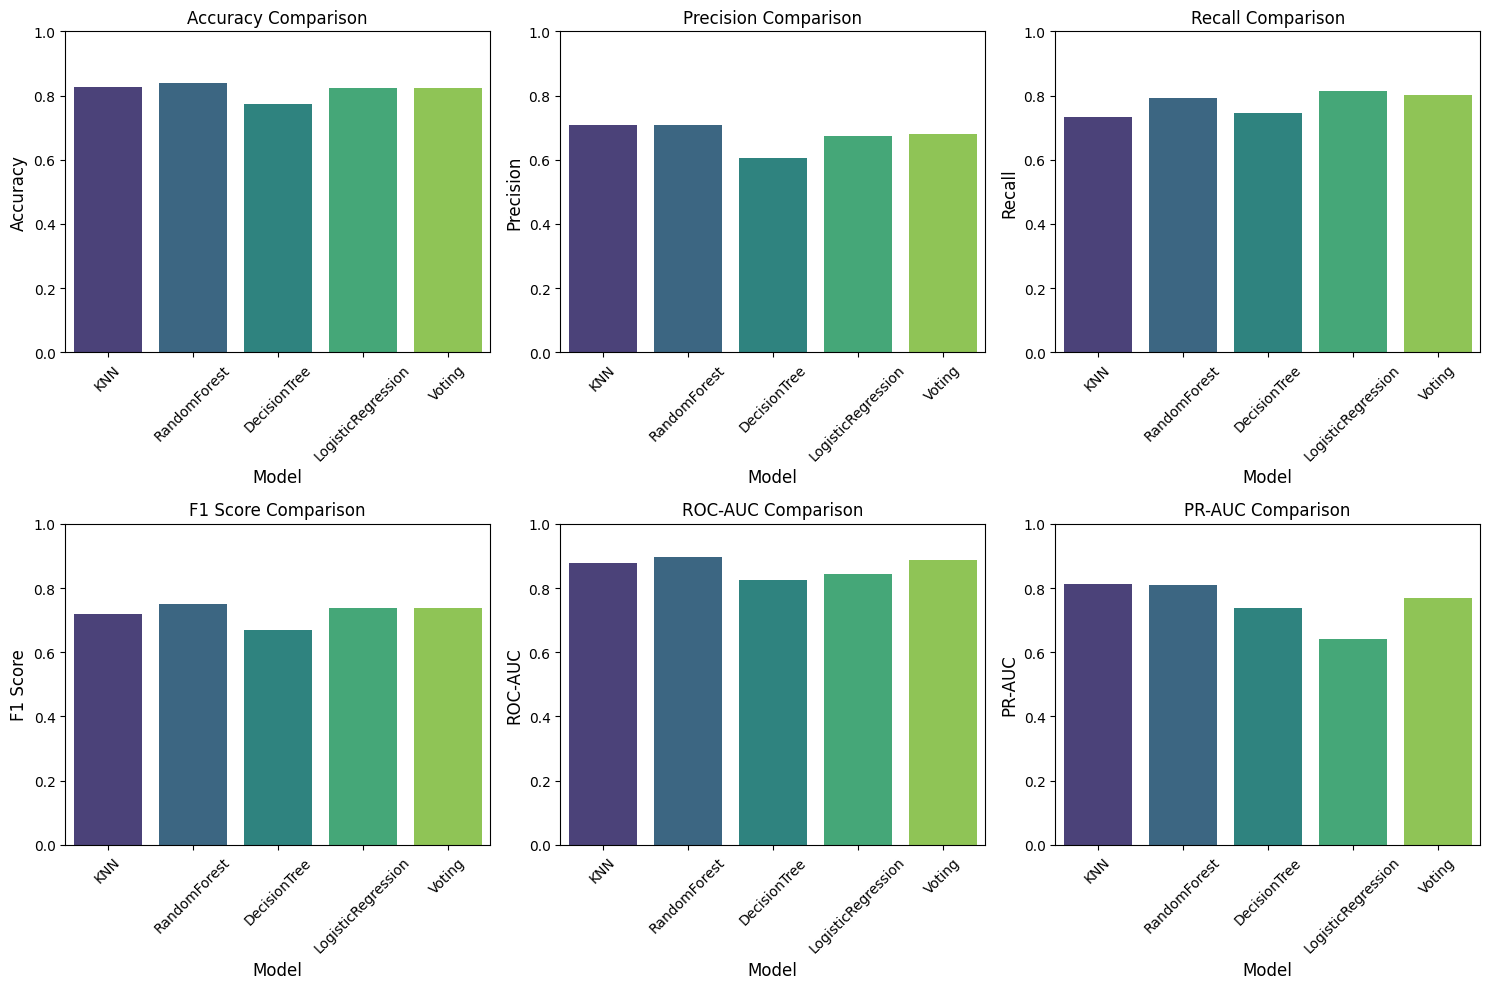

In [105]:
# Convert results to DataFrame
model_results_df = pd.DataFrame(model_results)
print("\nModel Performance Comparison:")
print(model_results_df)

# Visualize model performance
metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC-AUC", "PR-AUC"]
plt.figure(figsize=(15, 10))
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    model_results_df[metric] = pd.to_numeric(model_results_df[metric], errors="coerce")

    sns.barplot(
        x="Model",
        y=metric,
        data=model_results_df,
        hue="Model",
        palette="viridis",
        legend=False,
    )
    plt.title(f"{metric} Comparison")
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.ylabel(metric, fontsize=12)
    plt.xlabel("Model", fontsize=12)
plt.tight_layout()
plt.show()

In [106]:
best_model_name = model_results_df.loc[model_results_df["PR-AUC"].idxmax(), "Model"]
best_model = best_models[best_model_name]
print(f"\nBest model based on PR-AUC: {best_model_name}")


Best model based on PR-AUC: KNN


In [107]:
# 5. Feature Importance Analysis for the best model
if best_model_name in ["RandomForest", "DecisionTree"]:
    # For tree-based models, we can directly get feature importance
    feature_importance = pd.DataFrame(
        {"Feature": X.columns, "Importance": best_model.feature_importances_}
    ).sort_values("Importance", ascending=False)

    print("\nFeature Importance:")
    print(feature_importance)

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x="Importance", y="Feature", data=feature_importance)
    plt.title(f"Feature Importance ({best_model_name})")
    plt.tight_layout()
    plt.show()

In [108]:
# =============================================
# SHAP Analysis (Explainability for the Best Model)
# =============================================
print("\n=== SHAP Analysis ===")

try:
    # Create explainer based on model type
    if best_model_name in ["RandomForest", "DecisionTree"]:
        explainer = shap.TreeExplainer(best_model)
        shap_values = explainer.shap_values(X_test[:100])

        # For binary classification, we need to handle the shap_values array properly
        if isinstance(shap_values, list):
            shap_values = shap_values[1]  # Take values for class 1 (stroke)

    elif best_model_name == "LogisticRegression":
        explainer = shap.LinearExplainer(best_model, X_resampled)
        shap_values = explainer.shap_values(X_test[:100])
    else:  # For KNN or other models
        explainer = shap.KernelExplainer(best_model.predict_proba, X_resampled)
        shap_values = explainer.shap_values(X_test[:100])[1]  # For class 1

    # 1. Summary Plot (Global Feature Importance)
    plt.figure()
    shap.summary_plot(shap_values, X_test[:100], plot_type="bar", show=False)
    plt.title(f"SHAP Feature Importance ({best_model_name})")
    plt.tight_layout()
    plt.show()

    # 2. Detailed Feature Impact (Beeswarm Plot)
    plt.figure()
    shap.summary_plot(shap_values, X_test[:100], show=False)
    plt.title(f"SHAP Value Distribution ({best_model_name})")
    plt.tight_layout()
    plt.show()


except Exception as e:
    print(f"Error in SHAP visualization: {str(e)}")

Using 2467 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.



=== SHAP Analysis ===


  0%|          | 0/100 [00:00<?, ?it/s]

Error in SHAP visualization: The shape of the shap_values matrix does not match the shape of the provided data matrix.


<Figure size 640x480 with 0 Axes>

In [109]:
# 7. Final summary
print("=== CATEGORICAL DATA CONVERSION SUMMARY ===")
for col in categorical_cols:
    print(f"- {col}: Converted to numerical values")

print("\n")

print("\n=== STROKE PREDICTION MODEL SUMMARY ===")
print(f"Best model: {best_model_name}")
print(
    f"Best model PR-AUC: {model_results_df.loc[model_results_df['Model'] == best_model_name, 'PR-AUC'].values[0]:.4f}"
)
print(
    f"Best model F1 Score: {model_results_df.loc[model_results_df['Model'] == best_model_name, 'F1 Score'].values[0]:.4f}"
)
print(
    f"Best model Recall: {model_results_df.loc[model_results_df['Model'] == best_model_name, 'Recall'].values[0]:.4f}"
)
print(f"Best resampling method: {best_resampling_method_name}")

=== CATEGORICAL DATA CONVERSION SUMMARY ===
- gender: Converted to numerical values
- work_type: Converted to numerical values
- Residence_type: Converted to numerical values
- smoking_status: Converted to numerical values
- stroke: Converted to numerical values
- ever_married: Converted to numerical values



=== STROKE PREDICTION MODEL SUMMARY ===
Best model: KNN
Best model PR-AUC: 0.8135
Best model F1 Score: 0.7206
Best model Recall: 0.7340
Best resampling method: No resampling
